# Goal : Exploration of MCAR - Missing Completely At Random for handlisng missing values.

MCAR is one of the missing data mechanisms used to understand the pattern of missingness in Machine Learning

In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('MCAR Dataset.csv')
df

,Category,Price,Rating,Stock,Discount
0,NaN,5548.0,1.870322,NaN,0.0
1,NaN,3045.0,4.757798,NaN,38.0
2,NaN,4004.0,NaN,In Stock,0.0
3,NaN,4808.0,1.492085,NaN,33.0
4,NaN,1817.0,NaN,Out of Stock,23.0
...,...,...,...,...,...
4357,NaN,4436.0,4.728335,NaN,49.0
4358,B,6236.0,NaN,Out of Stock,4.0
4359,NaN,3283.0,NaN,Out of Stock,9.0
4360,D,2999.0,4.425995,NaN,40.0


In [3]:
# Lets do basic checkup of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  1614 non-null   object 
 1   Price     4188 non-null   float64
 2   Rating    2312 non-null   float64
 3   Stock     3010 non-null   object 
 4   Discount  3970 non-null   float64
dtypes: float64(3), object(2)
memory usage: 170.5+ KB


## MCAR – Missing Completely At Random
- **Hypothesis:** Suppose you want to test if Category is missing at random (not related to any other feature).
- **How to check:** Check whether missingness of Category varies across other columns. If it doesn't vary, it's likely MCAR.
- **Two ways to check:** **1)** Using group by(Numerical), crosstab(Non-Numerical)  **2)** Using tests like t-test, chi square test, ANOVA test etc. 
- **Other features** means if we are checking MCAR at category column against remaining columns then these remaining columns becomes other features.
- **Two scenarios :** 1) Numerical Features  2) Non Numerical Features
    - **1) Numerical Features** - When we have numerical features in remaining features then we can use groupby, t-test, ANOVA test etc.
    - **2) Categorical Features** - When we have categorical features in remaining features then we can use crosstab, chisquare test etc.
- When we have numerical columns & we use groupby then it use mean of that column for each part - missing & non missing and decide on that basis.
- When we have categorical columns & we use crosstab, it counts the occurances of different combinations of categories in both columns & decide on that basis.
- When we use different tests using scipy then it uses hypothesis test behind the scenes.
- **Which method to use? = Both ways needs to be used because they give double confirmation.**
    - Way 1 = groupby for Numeric, crosstab for Non Numeric
    - Way 2
        - = Tests for Numeric (t-test,ANOVA etc.)
        - = Tests for Non Numeric (chi square etc.) 

### Example of Numerical Features with groupby

In [4]:
# First create new column of 0 & 1
df['Category_missing'] = df['Category'].isnull().astype(int) # category_missing = 1, non_missing = 0

# List of numeric columns to check
columns_to_check = ['Discount', 'Price', 'Rating']

# when we have many columns in dataset, use below code instead of above manual list.
# It gives all numeric columns,dont forget to exclude that column on which MCAR is testing
# Means suppose we are testing MCAR in Price column, its a numeric and it would be in that, so drop it from the list.

# columns_to_check = df.select_dtypes(include='number').columns.tolist() 

# Create a dictionary to store results
mean_comparison = {}

for col in columns_to_check:
    mean_values = df.groupby('Category_missing')[col].mean()
    mean_comparison[col] = mean_values

# Create a DataFrame from the dictionary
summary_table = pd.DataFrame(mean_comparison).T # Transpose to make columns easier to read
summary_table

Category_missing,0,1
Discount,24.765914,24.371463
Price,5073.628773,4983.440897
Rating,3.042391,3.035833


**Interpretation: Category & Discount Columns** Numerical Columns
- Mean Discount (Category present): ~24.77
- Mean Discount (Category missing): ~24.37

1. If both groups (0 and 1) have similar Mean Discount(column), then Category column is probably MCAR.
2. The difference is very small (~0.39), suggesting no strong relationship between missingness in Category and Discount.
3. Same for Mean Rating(difference is very small).
4. But difference of Mean Price is very high. So, Overall Category column is not MCAR and needs further evaluaion using MAR or MNAR.
5. Even if all numerical columns have same or less difference between mean then we would go to check same for Non-numerical columns. 

**What we did:**
- We compared the average of the Numeric columns between two groups:
    - Rows where the Category value is not missing (Category_missing = 0)
    - Rows where the Category value is missing (Category_missing = 1)

### Example of Non Numerical Features with crosstab

In [5]:
pd.crosstab(df['Stock'], df['Category_missing']) # dropna=True is default

# This is basic crosstab which gives contingency table(count table)
# First it counts total occurances of 'In Stock' & 'Out of Stock' and then segregate them into 0 & 1. 

Category_missing,0,1
Stock,,
In Stock,595,918
Out of Stock,530,967


In [6]:
pd.crosstab(df['Stock'], df['Category_missing'],dropna=False) # dropna=False counts for NaN category also in category column

Category_missing,0,1
Stock,,
In Stock,595,918
Out of Stock,530,967
NaN,489,863


In [7]:
# normalize='index' converts them into proportion.
# Means 'In Stock' = we had 595(0) & 918(1) so total became 1513
# normalize='index' converts this proportion in percentage
# Means percentage of 595 out of 1513 and 918 out of 1513 which becomes 39.32 & 60.67 for 'In Stock' respectively
# Then it changes each row into proportions, i.e., each row sums to 1, basically divide by 100.

# First create new column of 0 & 1
df['Category_missing'] = df['Category'].isnull().astype(int) # category_missing = 1, non_missing = 0

# List of Non Numeric columns to check
columns_to_check = ['Stock']

# when we have many columns in dataset, use below code instead of above manual list.
# dont forget to drop column on which MCAR is being tested.Here we are testing on category column so it should be excluded from list.
#columns_to_check = df.select_dtypes(exclude='number').columns.tolist()

# Create a dictionary to store results
stock_crosstabs = {}

for col in columns_to_check:
    cross = pd.crosstab(df['Category_missing'], df[col], normalize='index')
    stock_crosstabs[col] = cross

# Create a dataframe from dictionary
summary_table = pd.concat(stock_crosstabs.values(), axis=1, keys=stock_crosstabs.keys()).T
summary_table

Category_missing           0         1
      Stock                           
Stock In Stock      0.528889  0.487003
      Out of Stock  0.471111  0.512997

**Interpretation : Non Numerical Columns**

- 1 is for missing values = True
- It shows small difference between 'In Stock'(0.48) & 'Out of Stock'(0.51)
- It is close but not identical, this small difference may be due to randomness.
- So we can say it follows MCAR, means we can consider dropping NaNs or simple impuatations like mean, mediean, mode in categorical column.
- Although, in few numerical columns MCAR is negative.
- That means, overall we need to consisder further evaluaion using MAR or MNAR istead of handling category column at this stage.

### Using different tests

- When results of groupby or crosstab are not very clear then we can take help of these tests to decide.
- Even if results are good, it is recommended to cross check using tests.
- **t-test and Mann–Whitney U test for Numerical columns.**
- **t-test** used when that column is normally distributed. **Mann–Whitney U** test used when that column is not normally distributed.
    - Means in our case we are using numerical columns Discount,Price,Rating.
    - So we will first check two distributions for each above column - 1)for category missing group  2)for category non missing group
    - If both groups are normally distributed for that column = **use t-test.**
    - If any group is not normal = use **Mann–Whitney U test.**
- **Chi Square test for Non Numerical columns**

In [8]:
# t-test
from scipy.stats import ttest_ind

# If the numeric variable is roughly normally distributed
group_0 = df[df['Category_missing'] == 0]['Price'].dropna()
group_1 = df[df['Category_missing'] == 1]['Price'].dropna()

# Above code splits the data into:
# group_0: Price values where Category is present
# group_1: Price values where Category is missing
# dropna() removes any missing prices, so you only compare valid numbers.

# Run t-test
t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)

# What this line is doing:
    # Calculates the difference in means between the two groups.
    # Checks: Is this difference big enough that it’s unlikely due to random chance?
# In short behind the scenes it computes:
    # The mean and standard deviation of each group.
    # The standard error (a measure of uncertainty).
    # Then it calculates a t-statistic — this tells how far apart the means are in standard error units.
    # It then computes a p-value from the t-distribution.

# Print the result of p_value
print(f"p-value: {p_val}")

# How to interprete p_value :
    # If p-value > 0.05 -> No strong evidence of difference -> Price is likely not related to missingness -> MCAR possible
    # If p-value <= 0.05 -> Strong evidence of difference -> Price may influence missingness -> Not MCAR

# Conclusion :
    # This way we statistically testing whether the average price differs between rows with and without missing values in the Category column 
    # if it does, that suggests missingness may not be random.

p-value: 0.3187885447795062


In [9]:
# Mann–Whitney U test
# Applicable when data is skewed or If it's not normally distributed (non-parametric)
# We are using a non-parametric test(doesn’t assume normal distribution),which is safer for skewed or messy data.

from scipy.stats import mannwhitneyu 

# Group the data (same as t-test)
group_0 = df[df['Category_missing'] == 0]['Price'].dropna()
group_1 = df[df['Category_missing'] == 1]['Price'].dropna()

# Run Mann–Whitney U Test
u_stat, p_val = mannwhitneyu(group_0, group_1, alternative='two-sided')

# What the test does behind the scenes:
    # 1) Combine all values from both groups into one list.
    # 2) Rank all values (lowest = 1, highest = N).
    # 3) Calculate the sum of ranks for each group.
    # 4) Then ask: "If both groups were from the same distribution, would we expect this difference in ranks?"
    # 5) Computes the U statistic, which measures how many times a value in one group ranks higher than a value in the other.
    # 6) Calculates the p-value: What is the probability of getting this U value (or more extreme) if the groups were from the same distribution?

# Print the result of p_value
print(f"p-value: {p_val}")

# How to interprete p_values?
    # If p > 0.05 -> Distributions are likely similar -> Missingness in Category may be MCAR
    # If p <= 0.05 -> Distributions differ -> Missingness is not random

# Conclusion
# It tests whether the distribution (not just mean) of a numerical column differs between missing and non-missing groups, 
# using ranking instead of averages - ideal when the data is not normally distributed.

# The Mann–Whitney U test checks if the values in one group tend to be higher or lower than in the other - without assuming normality.
# If one group consistently has higher or lower Price values, the test flags it.

p-value: 0.322391252368329


In [10]:
# chi square test
# Chi-Squared Test of Independence helps in categorical vs categorical comparison.
from scipy.stats import chi2_contingency

# Contingency table (counts, not normalized)
# This creates a 2D table of counts which shows how many times each combination occurred.
contingency = pd.crosstab(df['Stock'], df['Category_missing'])

# Chi-square test (check behind the scene working below)
chi2, p, dof, expected = chi2_contingency(contingency)

# Print the result of p_value
print(f'p-value: {p}')

# How to interprete p_values?
# If p > 0.05 -> Not significantly different from expected -> variables are likely independent -> MCAR possible.
# If p <= 0.05 -> Strong evidence of association -> Not MCAR.

# Conclusion 
# The Chi-squared test compares actual counts(Observed count) of combinations (like Stock vs Category_missing) to the counts you'd expect by chance.
# If they differ too much, it means the variables are likely dependent -> suggesting missingness is not completely random.

# It tests whether the pattern of missing values in a categorical column (like Category) is statistically independent from another 
# categorical variable (like Stock) by comparing observed vs expected frequencies.

p-value: 0.02882130828730913


**Behind the scenes of: chi2, p, dof, expected = chi2_contingency(contingency)**

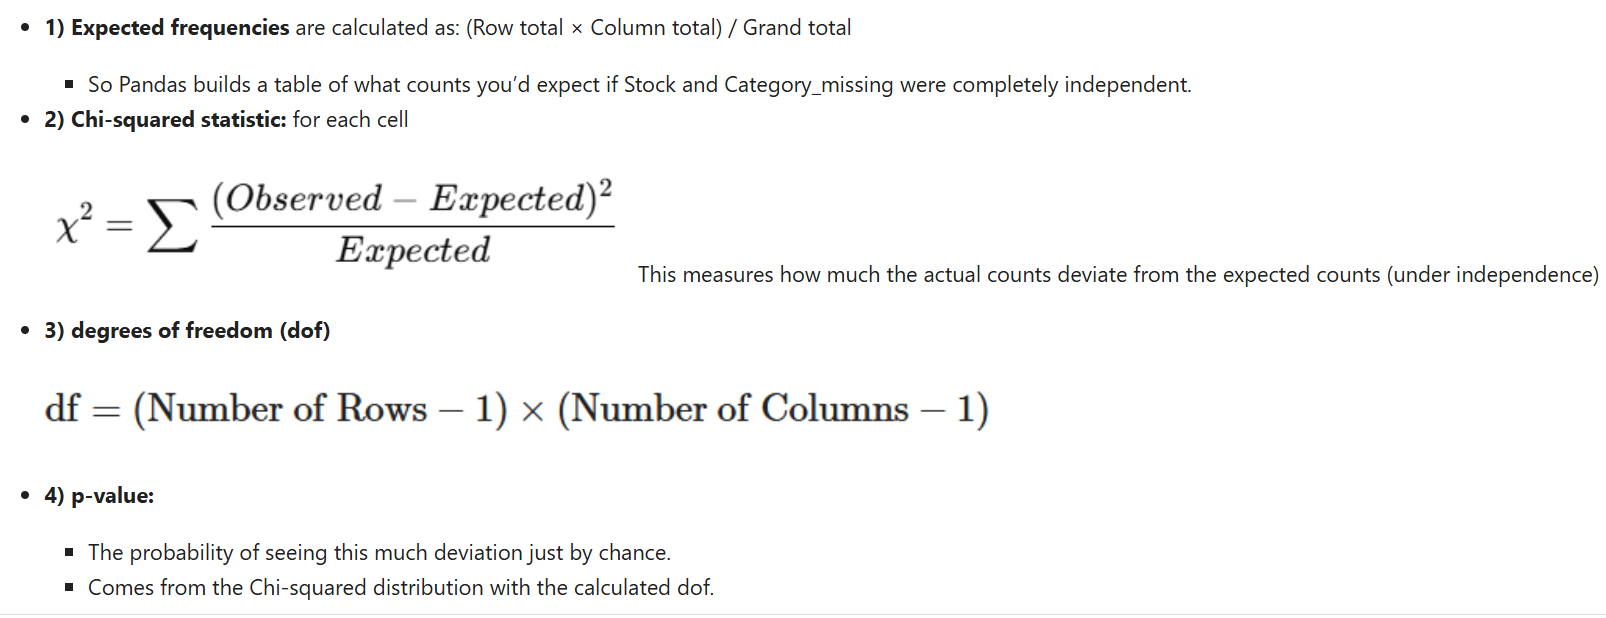

In [11]:
# Applying chi square test for multiple columns at a time using for loop (Summary Table)
categorical_cols = ['Stock']

from scipy.stats import chi2_contingency
import pandas as pd

results = []

for col in categorical_cols:
    # Create contingency table
    table = pd.crosstab(df[col], df['Category_missing'])
    
    # Perform chi-square test
    chi2, p, dof, expected = chi2_contingency(table)
    
    # Save results
    results.append({
        'Column': col,
        'p-value': p,
        'p_value Interpretation': 'Not MCAR' if p < 0.05 else 'Supports MCAR',
        'Strategy': 'Consider drop or simple imputation' if 'p_value Interpretation' == 'Not MCAR' else 'Refere MAR or MNAR for Imputation'
    })

# Create summary DataFrame
summary_df = pd.DataFrame(results)
summary_df

,Column,p-value,p_value Interpretation,Strategy
0,Stock,0.028821,Not MCAR,Refere MAR or MNAR for Imputation


In [12]:
# Applying t_test for multiple numerical columns at a time using for loop (Summary Table)

from scipy.stats import ttest_ind
import pandas as pd

numeric_cols = ['Price', 'Discount', 'Rating']
results = []

for col in numeric_cols:
    group_0 = df[df['Category_missing'] == 0][col].dropna()
    group_1 = df[df['Category_missing'] == 1][col].dropna()

    # Use t-test
    stat, p_val = ttest_ind(group_0, group_1, equal_var=False)

    interpretation = 'Not MCAR' if p_val < 0.05 else 'Supports MCAR'
    strategy = 'Consider drop or simple imputation' if interpretation == 'Not MCAR' else 'Refer MAR or MNAR for Imputation'

    results.append({
        'Column': col,
        'p-value': p_val,
        'p_value Interpretation': interpretation,
        'Strategy': strategy
    })

summary_df = pd.DataFrame(results)
summary_df

,Column,p-value,p_value Interpretation,Strategy
0,Price,0.318789,Supports MCAR,Refer MAR or MNAR for Imputation
1,Discount,0.402807,Supports MCAR,Refer MAR or MNAR for Imputation
2,Rating,0.893762,Supports MCAR,Refer MAR or MNAR for Imputation


In [13]:
# Applying Mann Whitney U test for multiple numerical columns at a time using for loop (Summary Table)

from scipy.stats import mannwhitneyu
import pandas as pd

numeric_cols = ['Price', 'Discount', 'Rating']
results = []

for col in numeric_cols:
    group_0 = df[df['Category_missing'] == 0][col].dropna()
    group_1 = df[df['Category_missing'] == 1][col].dropna()

    # Use Mann Whitney U test
    u_stat, p_val = mannwhitneyu(group_0, group_1, alternative='two-sided')

    interpretation = 'Not MCAR' if p_val < 0.05 else 'Supports MCAR'
    strategy = 'Consider drop or simple imputation' if interpretation == 'Not MCAR' else 'Refer MAR or MNAR for Imputation'

    results.append({
        'Column': col,
        'p-value': p_val,
        'p_value Interpretation': interpretation,
        'Strategy': strategy
    })

summary_df = pd.DataFrame(results)
summary_df

,Column,p-value,p_value Interpretation,Strategy
0,Price,0.322391,Supports MCAR,Refer MAR or MNAR for Imputation
1,Discount,0.398849,Supports MCAR,Refer MAR or MNAR for Imputation
2,Rating,0.883606,Supports MCAR,Refer MAR or MNAR for Imputation


### MCAR Final Words
**Purpose:**
- This helps in checking whether the missingness in the Category column is related to the values in the Discount column.
- If the averages are similar, it suggests that the missingness in Category is not influenced by Discount.
- In short,The missingness in the Category column does not appear to be directly related to the Discount column.
- This supports the idea that the missing data in Category is Missing Completely At Random (MCAR) - at least with respect to Discount.

**Handling:**
Drop rows or simple imputation (mean, median, mode) is safe.

**MCAR Strategy**

- If all remaining columns shows MCAR status to a particular column then its fine to drop NaN rows or use imputations like mean, median etc.
- But even a single column in dataframe shows a Not MCAR status then we should consider going to next steps like MAR or MNAR
- Because when its not MCAR and we consider imputation or dropping values, this means we are ignoring structure in data, natural relationship in data etc.
- This causes bias in analysis or modeling because it is faking values that break natuaral relationships.
- In short we should only treat a colunn as MCAR if its independent of all other columns. Only then dropping or simple imputation is safe & justified strategy.